In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor

# Housing Prices Competition for Kaggle Learn Users

/kaggle/input/home-data-for-ml-course

## 1. Dataset and EDA

In [2]:
housing_data = pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv", index_col = "Id")
housing_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [3]:
# housing_data.info()

In [4]:
# housing_data.describe().T

In [5]:
housing_data.SalePrice.isna().sum()

0

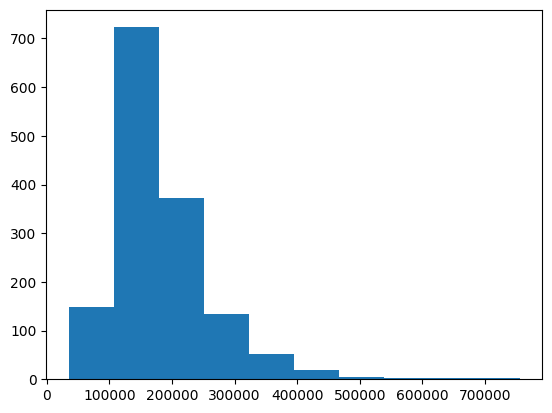

In [6]:
plt.hist(housing_data.SalePrice)
plt.show()

In [7]:
# housing_data.select_dtypes("object").nunique()

## 2. Preprocessing

In [8]:
# Remove rows with missing target, separate target from predictors
housing = housing_data.dropna(axis=0, subset=['SalePrice'])
target = housing.SalePrice              
housing = housing.drop(['SalePrice'], axis=1)

In [9]:
# Break off validation set from training data
housing_train, housing_val, target_train, target_val = train_test_split(housing, target, 
                                                                train_size = 0.8, test_size = 0.2,
                                                                random_state = 42)

In [10]:
# Select numerical columns
numerical_cols = [col_name for col_name in housing_train.columns if housing_train[col_name].dtype in ['int64', 'float64']]

# Select categorical columns 
categorical_cols = [col_name for col_name in housing_train.columns if housing_train[col_name].dtype == "object"]

In [11]:
# Preprocessing for numerical data
# numerical_transformer = SimpleImputer(strategy='constant')
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors = 3)),
    ('scaler', MinMaxScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit the preprocessor, so that it could be used to transform eval_set inside grid search
preprocessor.fit(housing_train)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(n_neighbors=3)),
                                                 ('scaler', MinMaxScaler())]),
                                 ['MSSubClass', 'LotFrontage', 'LotArea',
                                  'OverallQual', 'OverallCond', 'YearBuilt',
                                  'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                                  'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                                  '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                                  'GrLivArea', 'BsmtFullBath', 'BsmtHa...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'Neighborhood', 'Condition1',
                                  'Condition2', 'BldgType', 'HouseStyle',
                                  'RoofStyle', 'RoofMatl', 'Exterior1st',
                                  'Exterior2nd', 'MasVnrType', 'ExterQual',
                                  'ExterCond', 'Foundation', 'BsmtQual',
                                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', ...])])

In [12]:
# Define a model 
xgb = XGBRegressor(early_stopping_rounds = 10, random_state = 42)

# Define grid search
grid_search = GridSearchCV(xgb, 
                           cv = 5,
                           param_grid = {
                               "n_estimators": [100, 1000],
                               "learning_rate": [0.01, 0.1]
                           },
                           scoring = "neg_mean_absolute_error"
                          )

# Perform gridsearch with XGB model and preprocessed data
grid_search.fit(
    preprocessor.transform(housing_train), 
    target_train, 
    eval_set=[(preprocessor.transform(housing_val), target_val)], 
    verbose = False)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=10,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1],
                         'n_estimators': [100, 1000]},
             scoring='neg_mean_absolute_error')

In [13]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.676788,0.061827,0.003009,0.000082,0.01,100,"{'learning_rate': 0.01, 'n_estimators': 100}",-26902.865652,-29369.823184,-33158.344985,-28398.975422,-26323.238667,-28830.649582,2417.000564,4
1,4.982363,0.975593,0.011061,0.001846,0.01,1000,"{'learning_rate': 0.01, 'n_estimators': 1000}",-17277.514123,-20437.451088,-18952.564637,-17041.018777,-15816.405730,-17904.990871,1613.265526,3
2,0.575159,0.030284,0.003142,0.000192,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",-17101.405248,-20150.868857,-19331.020566,-17224.864740,-15441.929067,-17850.017696,1687.448561,2
3,0.633360,0.084595,0.003104,0.000202,0.1,1000,"{'learning_rate': 0.1, 'n_estimators': 1000}",-17110.722990,-20150.868857,-19271.193843,-17224.864740,-15402.646694,-17832.059425,1687.545135,1


In [14]:
grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 1000}

In [15]:
best_model = grid_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
best_model.score(preprocessor.transform(housing_train), target_train)

0.995198436266974

In [17]:
mean_absolute_error(target_val, best_model.predict(preprocessor.transform(housing_val)))

17015.518220248287

17682.454589041095

17560.22116438356


In [18]:
# Read test set
housing_test = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv", index_col = "Id")

# Get predictions
predictions_test = best_model.predict(preprocessor.transform(housing_test))

In [19]:
# Subbmission output
output = pd.DataFrame({'Id': housing_test.index,
                       'SalePrice': predictions_test})
output.to_csv('submission.csv', index = False)